In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import LogLocator, LogFormatter
from collections import OrderedDict

sns.set(style="whitegrid")

# Plot simple linreg experiments

In [2]:
def simulate_algo(
    algo_name="Fisher",
    iters=100,
    num_init_pts=10,
    pool_sz=10,
    measErr=False,
):
    col_name = "param_diffs"

    org_distr = pd.read_csv(
        f"../data/{algo_name}_param_diff_s{num_init_pts}_b{1}_p{pool_sz}_n{1000}_i{iters}_c{2}_m{measErr}.csv"
    )

    org_distr[col_name] = org_distr[col_name].apply(
        lambda x: np.fromstring(
            x.replace("\n", "").replace("[", "").replace("]", "").replace("  ", " "),
            sep=" ",
        )[
            1:
        ]  # only slope (beta1)
    )

    org_distr = org_distr.iloc[num_init_pts:]

    variances = []
    group_col = "Iteration"

    grouped = org_distr.groupby([group_col])
    for name, group in grouped:
        diffs = group[col_name]
        algo_var = np.mean(np.array(diffs**2), axis=0) 
        variances.append(algo_var)

    return pd.DataFrame(variances)

In [3]:
def plot_param_sims_mult_poolsz(
    logscale=False,
    iters=100,
    measErr=False,
    axes=None,
    fig=None,
    xstepSz=5,
):
    algos = ["Fisher", "BAIT", "CoreSet", "Random"]
    poolszs = [10, 100, 1000]  #
    figsz = (15, 4) if len(poolszs) > 1 else (15, 10)
    ylabel = r"$E\Vert\hat{\beta}-\beta^{\star}\Vert^2$"
    if axes is None:
        fig, axes = plt.subplots(1, len(poolszs), figsize=figsz)

    chungus_df = pd.DataFrame()
    for poolsz in poolszs:
        for ax_indx, algo in enumerate(algos):
            print(f"ALGO: {algo}, Pool Sizes: {poolsz}")
            mini_df = simulate_algo(
                algo, iters=iters, pool_sz=poolsz, measErr=measErr
            )
            mini_df.rename(
                columns={0: "Expected Squared Difference in Params"}, inplace=True
            )
            mini_df = mini_df.reset_index().rename(
                columns={"index": "Iteration"}
            )
            mini_df["Algorithm"] = algo if algo != "Fisher" else "Our Approach"
            mini_df["Pool Size"] = poolsz
            chungus_df = pd.concat([chungus_df, mini_df])
    chungus_df.reset_index(inplace=True, drop=True)
    chungus_df["Iteration"] += 10

    i = 0
    for ax, pool_sz in zip(axes, poolszs):
        data = chungus_df[chungus_df["Pool Size"] == pool_sz]
        ax.set_title(f"Pool Size = {pool_sz}", size=20)
        axplt = sns.lineplot(
            ax=ax,
            data=data,
            x="Iteration",
            y="Expected Squared Difference in Params",
            # marker="o",
            lw=4,
            hue="Algorithm",
        )
        axplt.set_xscale("log")
        axplt.set_yscale("log")
        axplt.set_xlabel("Labeled Sample Size", size=20)
        axplt.set_ylabel(ylabel, size=20)
        xvalues = np.arange(10, np.max(data.Iteration) + xstepSz, xstepSz)
        for x in xvalues:
            ax.axvline(x=x, color="lightgrey", linestyle="-", alpha=0.5)
        for y in [1e-1]:
            ax.axhline(y=y, color="lightgrey", linestyle="-", alpha=0.5)

        # Set xticks at the specific x-values (logarithmic values)
        ax.xaxis.set_major_formatter(plt.ScalarFormatter())
        ax.xaxis.set_major_locator(
            LogLocator(base=10.0, subs=np.arange(1.0, 10.0, 1.0), numticks=len(xvalues))
        )
        ax.set_xticks(xvalues)
        ax.xaxis.set_major_formatter(LogFormatter(base=10.0))
        ax.set_xticklabels([str(x) for x in xvalues])
        ax.tick_params(axis="x", labelsize=14)
        ax.tick_params(axis="y", labelsize=14)

        if i:
            ax.get_legend().remove()
            axplt.set_ylabel("")
        i += 1

    # Add black border to each subplot
    for ax in axes.flat:
        ax.spines["top"].set_color("black")
        ax.spines["right"].set_color("black")
        ax.spines["bottom"].set_color("black")
        ax.spines["left"].set_color("black")
    # Apply tight layout to adjust spacing
    plt.tight_layout()

    # Save the figure as a PDF
    path = f"../plots/linreg_i{iters}_l{100}_m{measErr}"
    plt.savefig(f"{path}.pdf", format="pdf", bbox_inches="tight")
    plt.savefig(f"{path}.png", bbox_inches="tight")

    return chungus_df[chungus_df.Iteration == 0]

ALGO: Fisher, Pool Sizes: 10
ALGO: BAIT, Pool Sizes: 10
ALGO: CoreSet, Pool Sizes: 10
ALGO: Random, Pool Sizes: 10
ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100
ALGO: Fisher, Pool Sizes: 1000
ALGO: BAIT, Pool Sizes: 1000
ALGO: CoreSet, Pool Sizes: 1000
ALGO: Random, Pool Sizes: 1000


,Iteration,Expected Squared Difference in Params,Algorithm,Pool Size


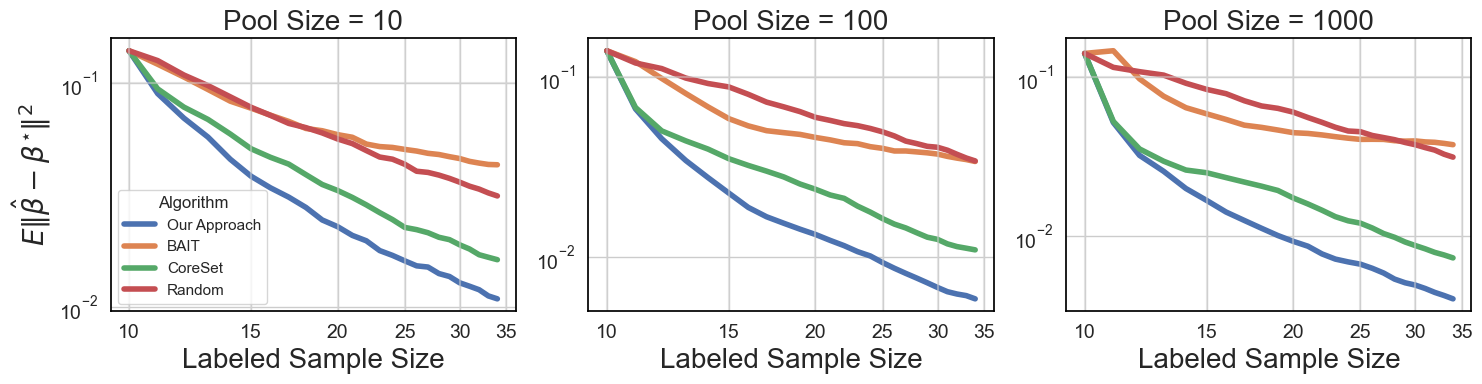

In [4]:
plot_param_sims_mult_poolsz(logscale=True, iters=25, measErr=False)

ALGO: Fisher, Pool Sizes: 10
ALGO: BAIT, Pool Sizes: 10
ALGO: CoreSet, Pool Sizes: 10
ALGO: Random, Pool Sizes: 10
ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100
ALGO: Fisher, Pool Sizes: 1000
ALGO: BAIT, Pool Sizes: 1000
ALGO: CoreSet, Pool Sizes: 1000
ALGO: Random, Pool Sizes: 1000


,Iteration,Expected Squared Difference in Params,Algorithm,Pool Size


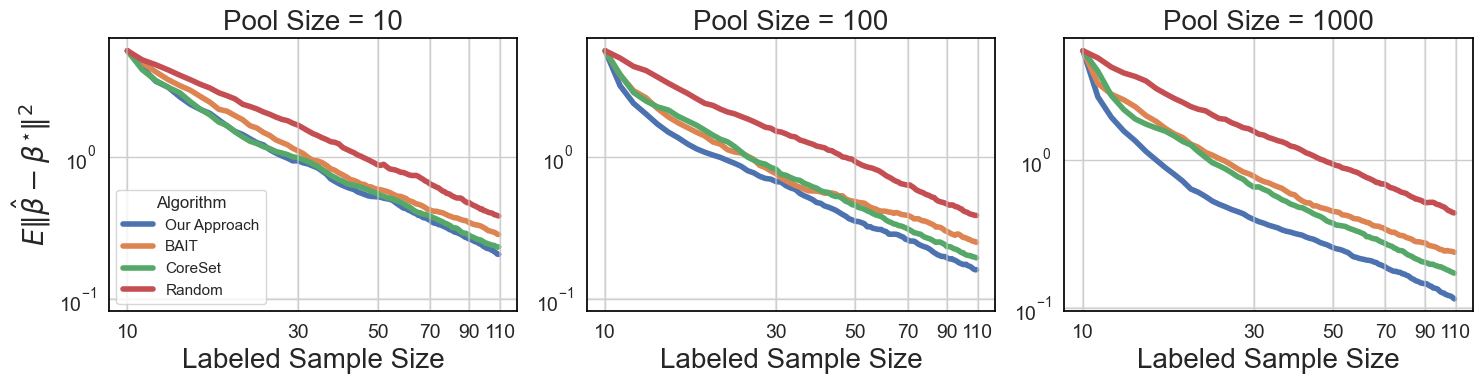

In [5]:
plot_param_sims_mult_poolsz(
    logscale=True, iters=100, measErr=True, xstepSz=20
)

In [6]:
def gain_ratio_exact(
    logscale=False,
    iters=100,
    measErr=False,
    axes=None,
    fig=None,
    xstepSz=5,
):
    algos = ["Fisher", "BAIT", "CoreSet", "Random"]
    poolszs = [10, 100, 1000]  #
    figsz = (15, 5) if len(poolszs) > 1 else (15, 10)
    ylabel = r"Gain Ratio"
    if axes is None:
        fig, axes = plt.subplots(1, len(poolszs), figsize=figsz, sharey=True)

    chungus_df = pd.DataFrame()
    for poolsz in poolszs:
        for ax_indx, algo in enumerate(algos):
            print(f"ALGO: {algo}, Pool Sizes: {poolsz}")
            mini_df = simulate_algo(
                algo, iters=iters, pool_sz=poolsz, measErr=measErr
            )
            mini_df.rename(
                columns={0: "Expected Squared Difference in Params"}, inplace=True
            )
            mini_df = mini_df.reset_index().rename(
                columns={"index": "Iteration"}
            )
            mini_df["Algorithm"] = algo if algo != "Fisher" else "Our Approach"
            mini_df["Pool Size"] = poolsz
            chungus_df = pd.concat([chungus_df, mini_df])
    chungus_df.reset_index(inplace=True, drop=True)
    chungus_df["Iteration"] += 10

    i = 0
    for ax, pool_sz in zip(axes, poolszs):
        data = chungus_df[chungus_df["Pool Size"] == pool_sz].copy()
        data["Gain Ratio"] = data.apply(
            lambda row: (
                data.loc[
                    (data["Algorithm"] == "Random")
                    & (data["Iteration"] == row.Iteration)
                ]
                .reset_index(drop=True)
                .iloc[0]["Expected Squared Difference in Params"]
                / row["Expected Squared Difference in Params"]
            ),
            axis=1,
        )

        ax.set_title(f"Pool Size = {pool_sz}", size=20)
        axplt = sns.lineplot(
            ax=ax,
            data=data,
            x="Iteration",
            y="Gain Ratio",
            # marker="o",
            lw=4,
            hue="Algorithm",
        )
        axplt.set_xscale("log")
        axplt.set_yscale("log")
        axplt.set_xlabel("Labeled Sample Size", size=20)
        axplt.set_ylabel(ylabel, size=20)

        xvalues = np.arange(10, np.max(data.Iteration) + xstepSz, xstepSz)
        yvalues = np.arange(1, np.max(data["Gain Ratio"]) + 1, 1)
        for x in xvalues:
            ax.axvline(x=x, color="lightgrey", linestyle="-", alpha=0.5)
        for y in yvalues:
            ax.axhline(y=y, color="lightgrey", linestyle="-", alpha=0.5)

        ax.set_xticks(xvalues)
        ax.xaxis.set_major_formatter(LogFormatter(base=10.0))
        ax.set_xticklabels([str(x) for x in xvalues])
        ax.set_yticks(yvalues)
        ax.yaxis.set_major_formatter(LogFormatter(base=10.0))
        ax.set_yticklabels([str(y) for y in yvalues])
        ax.tick_params(axis="x", labelsize=14)
        ax.tick_params(axis="y", labelsize=14)

        if i:
            ax.get_legend().remove()
            axplt.set_ylabel("")
        i += 1

    # Add black border to each subplot
    for ax in axes.flat:
        ax.spines["top"].set_color("black")
        ax.spines["right"].set_color("black")
        ax.spines["bottom"].set_color("black")
        ax.spines["left"].set_color("black")

    # Apply tight layout to adjust spacing
    plt.tight_layout()

    # Save the figure as a PDF
    path = f"../plots/exact_gain_i{iters}_l{100}_m{measErr}"
    plt.savefig(f"{path}.pdf", format="pdf", bbox_inches="tight")
    plt.savefig(f"{path}.png", bbox_inches="tight")

    return chungus_df[chungus_df.Iteration == 0]

ALGO: Fisher, Pool Sizes: 10
ALGO: BAIT, Pool Sizes: 10
ALGO: CoreSet, Pool Sizes: 10
ALGO: Random, Pool Sizes: 10
ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100
ALGO: Fisher, Pool Sizes: 1000
ALGO: BAIT, Pool Sizes: 1000
ALGO: CoreSet, Pool Sizes: 1000
ALGO: Random, Pool Sizes: 1000
ALGO: Fisher, Pool Sizes: 10
ALGO: BAIT, Pool Sizes: 10
ALGO: CoreSet, Pool Sizes: 10
ALGO: Random, Pool Sizes: 10
ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100
ALGO: Fisher, Pool Sizes: 1000
ALGO: BAIT, Pool Sizes: 1000
ALGO: CoreSet, Pool Sizes: 1000
ALGO: Random, Pool Sizes: 1000


,Iteration,Expected Squared Difference in Params,Algorithm,Pool Size


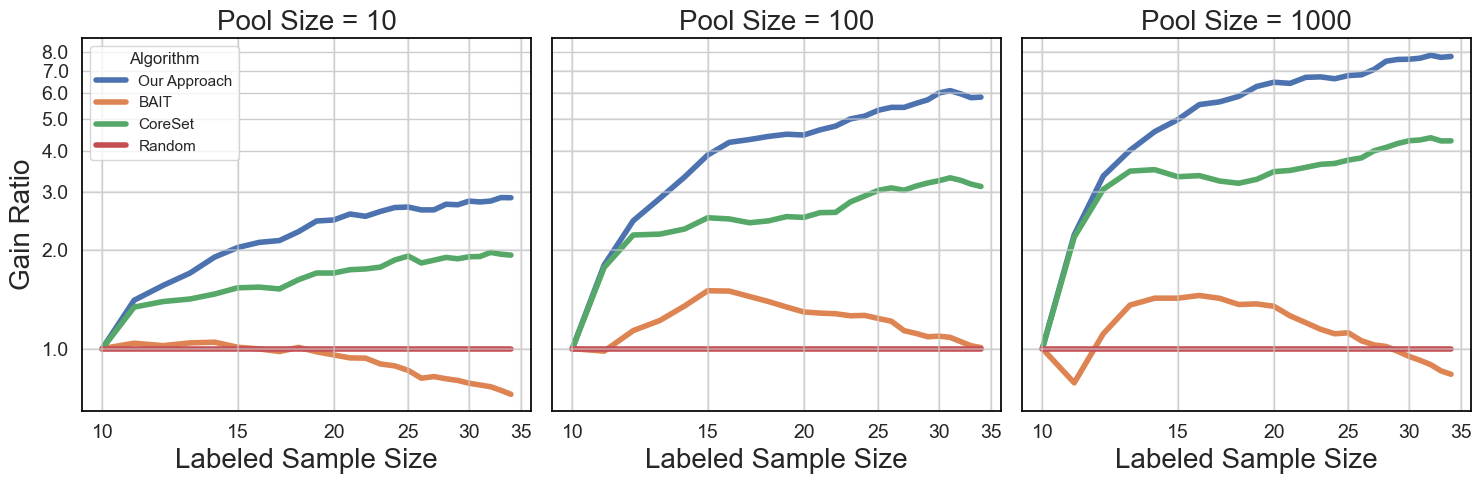

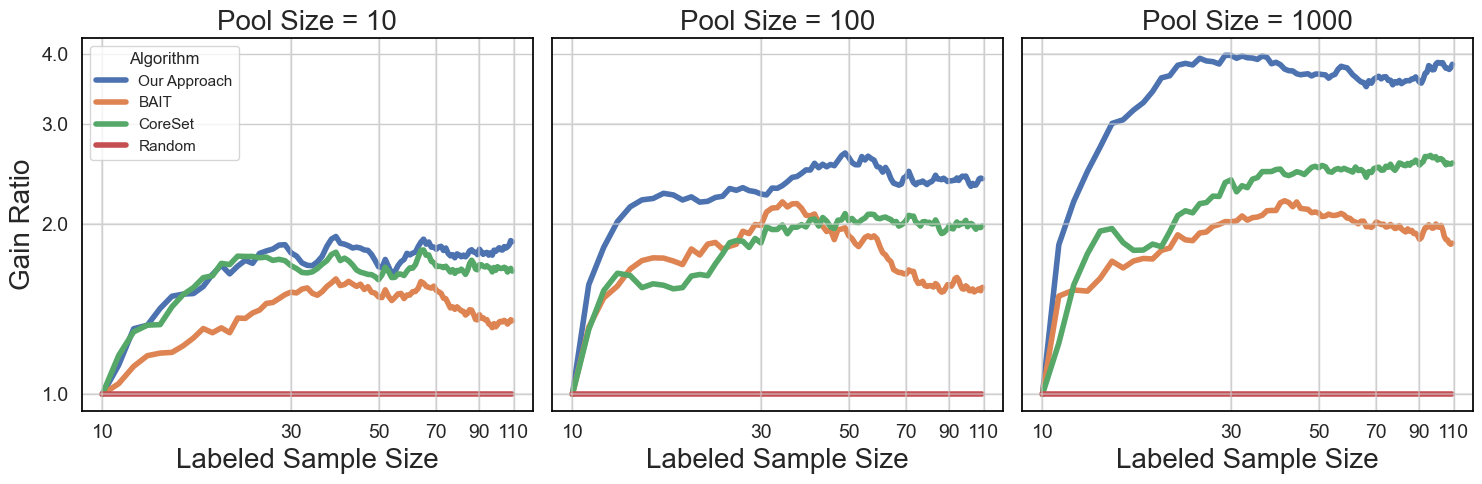

In [7]:
gain_ratio_exact(logscale=True, iters=25, measErr=False)
gain_ratio_exact(logscale=True, iters=100, measErr=True, xstepSz=20)

# Plot multivariate experiments

In [8]:
def plot_sampled_pts(num_coeff):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # no meas error
    df = pd.read_csv(f"../data/multiVar_s10_b1_p100_n1_i1000_c{num_coeff}_m{False}.csv")
    df = df[df.Algorithm != "Our Approach (Pool Size = 100, Budget = 10)"]
    df["Algorithm"] = df["Algorithm"].replace(
        {
            "Our Approach (Pool Size = 100, Budget = 1)": "Our Approach (Pool Size = 100)",
            "Our Approach (Pool Size = 1000, Budget = 1)": "Our Approach (Pool Size = 1000)",
        }
    )
    df = df.sort_values(by="Algorithm", ascending=True)
    
    # Scatterplot with hue
    sns.scatterplot(
        data=df.iloc[10:], x="X1", y="X2", hue="Algorithm", s=40, palette="colorblind", ax=axes[0]
    )


    # yes meas error
    df = pd.read_csv(f"../data/multiVar_s10_b1_p100_n1_i1000_c{num_coeff}_m{True}.csv")
    df = df[df.Algorithm != "Our Approach (Pool Size = 100, Budget = 10)"]
    df["Algorithm"] = df["Algorithm"].replace(
        {
            "Our Approach (Pool Size = 100, Budget = 1)": "Our Approach (Pool Size = 100)",
            "Our Approach (Pool Size = 1000, Budget = 1)": "Our Approach (Pool Size = 1000)",
        }
    )
    df = df.sort_values(by="Algorithm", ascending=True)
    
    # Scatterplot with hue
    sns.scatterplot(
        data=df.iloc[10:], x="X1", y="X2", hue="Algorithm", s=40, palette="colorblind", ax=axes[1]
    )
    
    for ax in axes:
        ax.legend(
            loc=3,
            borderaxespad=0.5,
            markerscale=2,
            fancybox=True,
            framealpha=0.95,
            ncols=2,
            facecolor="white",
            prop={"size": 10},
        )
        
        # Add labels
        ax.set_xlabel(r"$X_1$", size=22)
        ax.set_ylabel(r"$X_2$", size=22)

        x_min, x_max = ax.get_xlim() 
        y_min, y_max = ax.get_ylim()
        ax.set_xlim(x_min - 1, x_max + 1)  
        ax.set_ylim(y_min - 1, y_max + 1)  
        for spine in ax.spines.values():
            spine.set_edgecolor("black")
            spine.set_linewidth(2) 

    plt.savefig(f"../plots/multivar-labeledX-chi2-c{num_coeff}.pdf", format='pdf', bbox_inches="tight")
    plt.savefig(f"../plots/multivar-labeledX-chi2-c{num_coeff}.pdf", bbox_inches="tight")

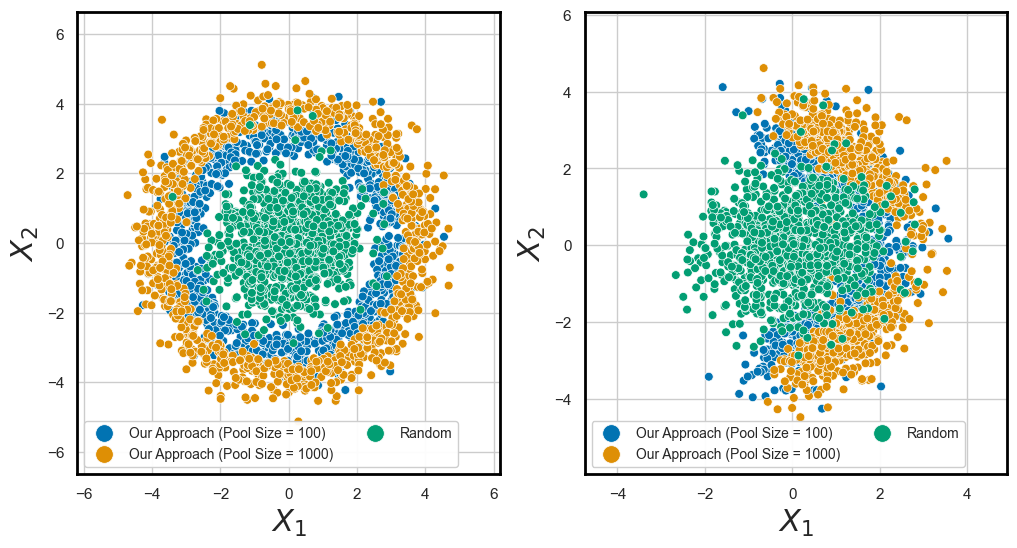

In [9]:
plot_sampled_pts(5)

In [10]:
def plot_sampled_pts2(num_coeff=2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # no meas error
    df = pd.read_csv(f"../data/multiVar_s10_b1_p100_n1_i1000_c{num_coeff}_m{False}.csv")
    df = df[df.Algorithm != "Our Approach (Pool Size = 100, Budget = 10)"]
    df["Algorithm"] = df["Algorithm"].replace(
        {
            "Our Approach (Pool Size = 100, Budget = 1)": "Our Approach (Pool Size = 100)",
            "Our Approach (Pool Size = 1000, Budget = 1)": "Our Approach (Pool Size = 1000)",
        }
    )
    df = df.sort_values(by="Algorithm", ascending=True)
    df["Algorithm"] = df["Algorithm"].astype("category")
    
    # Scatterplot with hue
    sns.histplot(
        data=df.iloc[10:], bins=100, x="X1", hue="Algorithm", palette="colorblind", ax=axes[0], stat="probability"
    )


    # yes meas error
    df = pd.read_csv(f"../data/multiVar_s10_b1_p100_n1_i1000_c{num_coeff}_m{True}.csv")
    df = df[df.Algorithm != "Our Approach (Pool Size = 100, Budget = 10)"]
    df["Algorithm"] = df["Algorithm"].replace(
        {
            "Our Approach (Pool Size = 100, Budget = 1)": "Our Approach (Pool Size = 100)",
            "Our Approach (Pool Size = 1000, Budget = 1)": "Our Approach (Pool Size = 1000)",
        }
    )
    df = df.sort_values(by="Algorithm", ascending=True)
    df["Algorithm"] = df["Algorithm"].astype("category")
    
    sns.histplot(
        data=df.iloc[10:], bins=100, x="X1", hue="Algorithm", palette="colorblind", ax=axes[1], stat="probability"
    )
    
    for ax in axes:
        # Add labels
        ax.set_xlabel(r"$X$", size=22)
        ax.set_ylabel(r"Probability Density", size=22)
        
        x_min, x_max = ax.get_xlim() 
        for spine in ax.spines.values():
            spine.set_edgecolor("black")
            spine.set_linewidth(2) 

    plt.savefig(f"../plots/multivar-labeledX-chi2-c{num_coeff}.pdf", format='pdf', bbox_inches="tight")
    plt.savefig(f"../plots/multivar-labeledX-chi2-c{num_coeff}.png", bbox_inches="tight")

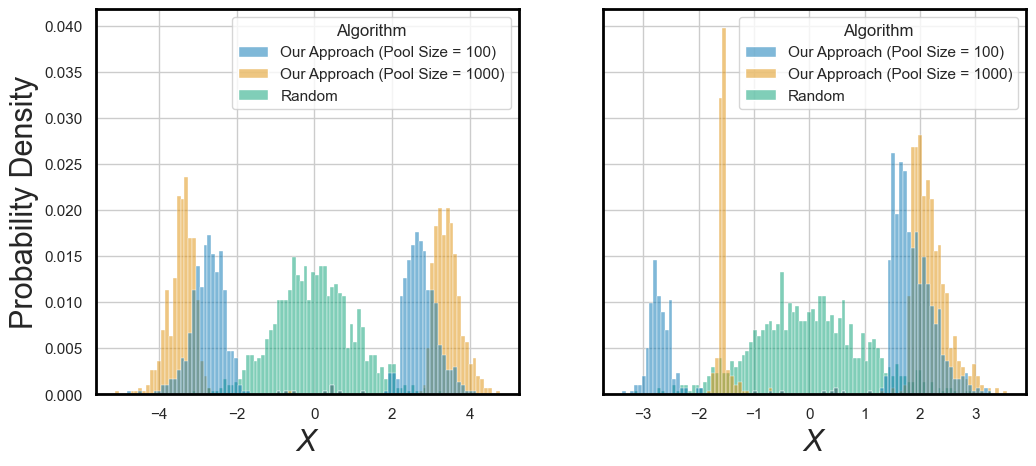

In [11]:
plot_sampled_pts2(2)